<a href="https://colab.research.google.com/github/mikaelsouza/fraud-detection/blob/master/notebooks/colab-research-files/mnist_autoencoder_02_11_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
import numpy as np
from sklearn import model_selection, preprocessing, metrics, utils
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU

Using TensorFlow backend.


In [0]:
# Loading dataset
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train = X_train / 255
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
X_test = X_test / 255


In [0]:
# Filtering dataset to use only 2 classes

def get_labeled_instances(X_data, y_data, wanted_label):
  filtered_data = []
  for data, label in zip(X_data, y_data):
    if label == wanted_label:
      filtered_data.append((data, label))
  new_X, new_y = zip(*filtered_data)
  new_X = np.array(new_X)
  new_y = np.array(new_y)
  return new_X, new_y

class_0, label_0 = get_labeled_instances(X_train, y_train, 0)
class_1, label_1 = get_labeled_instances(X_train, y_train, 1)

test_class_0, test_label_0 = get_labeled_instances(X_test, y_test, 0)
test_class_1, test_label_1 = get_labeled_instances(X_test, y_test, 1)

label_0 = label_0.reshape(-1, 1)
label_1 = label_1.reshape(-1, 1)

In [4]:
# Generating a imbalanced dataframe

imbalanced_class_0 = class_0[:200]
imbalanced_label_0 = label_0[:200]

imbalanced_data_0 = np.concatenate((imbalanced_class_0,
                                    imbalanced_label_0),
                                    axis=1)

imbalanced_data_1 = np.concatenate((class_1, label_1), axis=1)

print(imbalanced_data_0.shape)
print(imbalanced_data_1.shape)

columns = [*list(range(784)), 'class']

imbalanced_dataframe = pd.DataFrame(np.concatenate((imbalanced_data_0,
                                                    imbalanced_data_1)),
                                    columns=columns)

imbalanced_dataframe.head()

# Defining test dataset using 0s and 1s.

X_test = np.concatenate((test_class_0,
                         test_class_1,),
                        axis=0)

y_test = np.concatenate((test_label_0,
                         test_label_1,),
                        axis=0)

(200, 785)
(6742, 785)


In [0]:
# Function to get stratified samples
# https://stackoverflow.com/questions/44114463/stratified-sampling-in-pandas#
def stratified_sample(dataframe, feature, size):
  return dataframe.groupby(feature, group_keys=False).apply(lambda x: x.sample(min(len(x), size)))

In [6]:
# Defining other necessary variables

epochs = 400
batch_size = 256

X_train, y_train = imbalanced_dataframe.drop(['class'], axis=1), imbalanced_dataframe['class']
X_train = np.array(X_train).reshape(-1, 784)
y_train = y_train.reshape(-1, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  import sys


In [0]:
def plot_mnist_value(sample):
  sample = sample * 255
  pixels = sample
  pixels = pixels.reshape((28, 28))
  plt.imshow(pixels, cmap='gray')
  plt.show()
  

def sample_images(predictions, labels):
  r, c = 2, 5
  gen_imgs = predictions
  gen_imgs = gen_imgs.reshape(-1, 28, 28)
  
  fig, axs = plt.subplots(r, c)
  for j in range(c):
      axs[0,j].imshow(gen_imgs[j], cmap='gray')
      axs[0,j].set_title("Digit: %d" % labels[j])
      axs[0,j].axis('off')
  for j in range(-1, - c - 1, -1):
      axs[1,j].imshow(gen_imgs[j], cmap='gray')
      axs[1,j].set_title("Digit: %d" % labels[j])
      axs[1,j].axis('off')
  plt.show()
  plt.close()


In [0]:
# Defining autoencoder

encoder = keras.models.Sequential()
encoder.add(Dense(1024, input_dim=784))
encoder.add(LeakyReLU(0.2))
encoder.add(Dropout(0.6))
encoder.add(Dense(256))
encoder.add(LeakyReLU(0.2))
encoder.add(Dropout(0.6))

# Defining encoded layer

code = keras.layers.Dense(128)

# Defining decoder

decoder = keras.models.Sequential()
decoder.add(Dense(256, input_shape=(128,)))
decoder.add(LeakyReLU(0.2))
decoder.add(Dropout(0.6))
decoder.add(Dense(1024))
decoder.add(LeakyReLU(0.2))
decoder.add(Dropout(0.6))
decoder.add(Dense(784, activation='sigmoid'))

encoder_input = keras.layers.Input(shape=(784,))

ae_model = decoder(code(encoder(encoder_input)))
autoencoder = keras.models.Model(encoder_input, ae_model)

adam = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

autoencoder.compile(optimizer='adam', loss='mse')

In [9]:
history = autoencoder.fit(X_train, X_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(X_test, X_test))

Train on 6942 samples, validate on 2115 samples
Epoch 1/400
6942/6942 [==============================] - 4s 648us/step - loss: 0.0768 - val_loss: 0.1061
Epoch 2/400
6942/6942 [==============================] - 4s 536us/step - loss: 0.0494 - val_loss: 0.1031
Epoch 3/400
6942/6942 [==============================] - 4s 522us/step - loss: 0.0403 - val_loss: 0.0786
Epoch 4/400
6942/6942 [==============================] - 4s 514us/step - loss: 0.0267 - val_loss: 0.0590
Epoch 5/400
6942/6942 [==============================] - 4s 520us/step - loss: 0.0198 - val_loss: 0.0448
Epoch 6/400
6942/6942 [==============================] - 3s 501us/step - loss: 0.0173 - val_loss: 0.0423
Epoch 7/400
6942/6942 [==============================] - 3s 497us/step - loss: 0.0153 - val_loss: 0.0375
Epoch 8/400
6942/6942 [==============================] - 3s 503us/step - loss: 0.0139 - val_loss: 0.0370
Epoch 9/400
6942/6942 [==============================] - 4s 507us/step - loss: 0.0125 - val_loss: 0.0325
Epoch 1

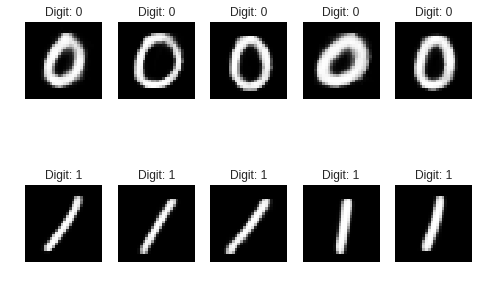

In [10]:
# Sampling examples passed through autoencoder
prediction = autoencoder.predict(X_test)
sample_images(prediction, y_test)

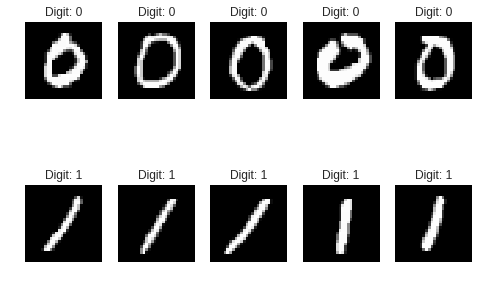

In [11]:
# Same examples but their original form for comparison
sample_images(X_test, y_test)

In [0]:
# Saving model to be loaded on GAN later

encoder_json = encoder.to_json()
decoder_json = decoder.to_json()
ae_json = autoencoder.to_json()

with open("encoder.json", "w") as json_file:
    json_file.write(encoder_json)
with open("decoder.json", "w") as json_file:
    json_file.write(decoder_json)
with open("autoencoder.json", "w") as json_file:
    json_file.write(ae_json)

# Saving weights to disk

encoder.save_weights('encoder.h5')
decoder.save_weights('decoder.h5')
autoencoder.save_weights('autoencoder.h5')